In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-GC-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20201005-DataSheet-Maria4.csv"
run = "runMaria4"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: runMaria4-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,MS-76_S1,nomatch,CARDPLGHWYDDSGTGGYWGQGTLVT,7268,1,IGHV1-2,"IGHJ4,IGHJ1",750,0.103192,7.159110,0.054855
1,MS-76_S1,nomatch,CAPCTGFGSGWSDAFDIWGQGTMVT,5458,1,IGHV2-5,IGHJ3,6,0.001099,5.376228,0.054855
2,MS-76_S1,nomatch,CARDVGGDTSWYNPGPGMDVWGQGTTVT,4455,1,IGHV1-2,IGHJ6,444,0.099663,4.388255,0.054855
3,MS-76_S1,nomatch,CARHQLEVYFDYWGQGTLVT,3571,1,IGHV5-51,IGHJ4,32,0.008961,3.517499,0.054855
4,MS-76_S1,nomatch,CARGQIVRFRDFTTRDKLTWFDSWGQGTLVT,2256,1,IGHV1-8,IGHJ5,624,0.276596,2.222200,0.054855


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
11795,MS-85_S10,CAREGRSRGRPPNYYYGMDVWGQGTTVT,70479,1,451,0.006399,77.374627,0.018454
13417,MS-85_S10,CARSNITMIGINDLWGQGTLVT,911,1,1763,1.935236,1.000132,0.018454
11217,MS-85_S10,CARDPQSITGLDYWGQGTLVT,550,1,7,0.012727,0.603812,0.018454
11055,MS-85_S10,CARDLGGNFDYWGQGTLVT,484,1,10,0.020661,0.531354,0.018454
9931,MS-85_S10,CAKDSYSSSLRFGDGQGTLVT,418,1,2,0.004785,0.458897,0.018454


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,filename
0,MS-76,MS-76,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201005-maria,S1,GC,human,BCRh,Unknown,MS-76,no,MS-76_S1_L001_R1_001.fastq.gz
1,MS-77,MS-77,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201005-maria,S2,GC,human,BCRh,Unknown,MS-77,no,MS-77_S2_L001_R1_001.fastq.gz
2,MS-78,MS-78,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201005-maria,S3,GC,human,BCRh,Unknown,MS-78,no,MS-78_S3_L001_R1_001.fastq.gz
3,MS-79,MS-79,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201005-maria,S4,GC,human,BCRh,Unknown,MS-79,no,MS-79_S4_L001_R1_001.fastq.gz
4,MS-82,MS-82,NaN,NaN,NaN,NaN,NaN,NaN,runXXX-20201005-maria,S7,GC,human,BCRh,Unknown,MS-82,no,MS-82_S7_L001_R1_001.fastq.gz


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,MS-76_S1,Unknown
1,MS-77_S2,Unknown
2,MS-78_S3,Unknown
3,MS-79_S4,Unknown
4,MS-82_S7,Unknown


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,MS-85_S10,CAREGRSRGRPPNYYYGMDVWGQGTTVT,70479,1,451,0.006399,77.374627,0.018454,Unknown
1,MS-85_S10,CARSNITMIGINDLWGQGTLVT,911,1,1763,1.935236,1.000132,0.018454,Unknown
2,MS-85_S10,CARDPQSITGLDYWGQGTLVT,550,1,7,0.012727,0.603812,0.018454,Unknown
3,MS-85_S10,CARDLGGNFDYWGQGTLVT,484,1,10,0.020661,0.531354,0.018454,Unknown
4,MS-85_S10,CAKDSYSSSLRFGDGQGTLVT,418,1,2,0.004785,0.458897,0.018454,Unknown


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                      Unknown                                      \
Sample                      MS-76_S1 MS-77_S2 MS-78_S3 MS-79_S4 MS-82_S7   
cdr3pep                                                                    
AWGYWGQGTLVT                     0.0      0.0      0.0      0.0      0.0   
CAAAFLVTHNWFDPWGQGTLVT           0.0      0.0      0.0      0.0      0.0   
CAADSGSYYPPGRECAFDIWGQGTMVT      0.0      0.0      0.0      0.0      0.0   
CAADYYDSSGYPRDDAFDIWGQGTTVT      0.0      0.0      0.0      0.0      0.0   
CAAEFDYGGNNWFDPWGQGTLVT          0.0      0.0      0.0     37.0      0.0   

Patient                                                  
Sample                      MS-83_S8 MS-84_S9 MS-85_S10  
cdr3pep                                                  
AWGYWGQGTLVT                     0.0      0.0       4.0  
CAAAFLVTHNWFDPWGQGTLVT           0.0      0.0       2.0  
CAADSGSYYPPGRECAFDIWGQGTMVT      0.0      0.0       2.0  
CAADYYDSSGYPRDDAFDIWGQGTTVT      0.0      0.0       1.0  
CAAEFDYGGNNWFDPWGQGTLVT          0.0      0.0       0.0

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient            Unknown                                                    \
Sample            MS-76_S1  MS-77_S2  MS-78_S3  MS-79_S4  MS-82_S7  MS-83_S8   
Patient Sample                                                                 
Unknown MS-76_S1  1.000000  0.283177  0.008316  0.000971  0.000068  0.000233   
        MS-77_S2  0.283177  1.000000  0.017238  0.000417  0.000010  0.000149   
        MS-78_S3  0.008316  0.017238  1.000000  0.191160  0.000031  0.000127   
        MS-79_S4  0.000971  0.000417  0.191160  1.000000  0.000046  0.000077   
        MS-82_S7  0.000068  0.000010  0.000031  0.000046  1.000000  0.949673   

Patient                               
Sample            MS-84_S9 MS-85_S10  
Patient Sample                        
Unknown MS-76_S1  0.000316  0.003551  
        MS-77_S2  0.000274  0.002489  
        MS-78_S3  0.005626  0.003624  
        MS-79_S4  0.000071  0.000822  
        MS-82_S7  0.000273  0.065656

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote runMaria4-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.034736090554933e-05
max value: 1.0
Wrote runMaria4-similarity-IGH_HUMAN.pdf to disk


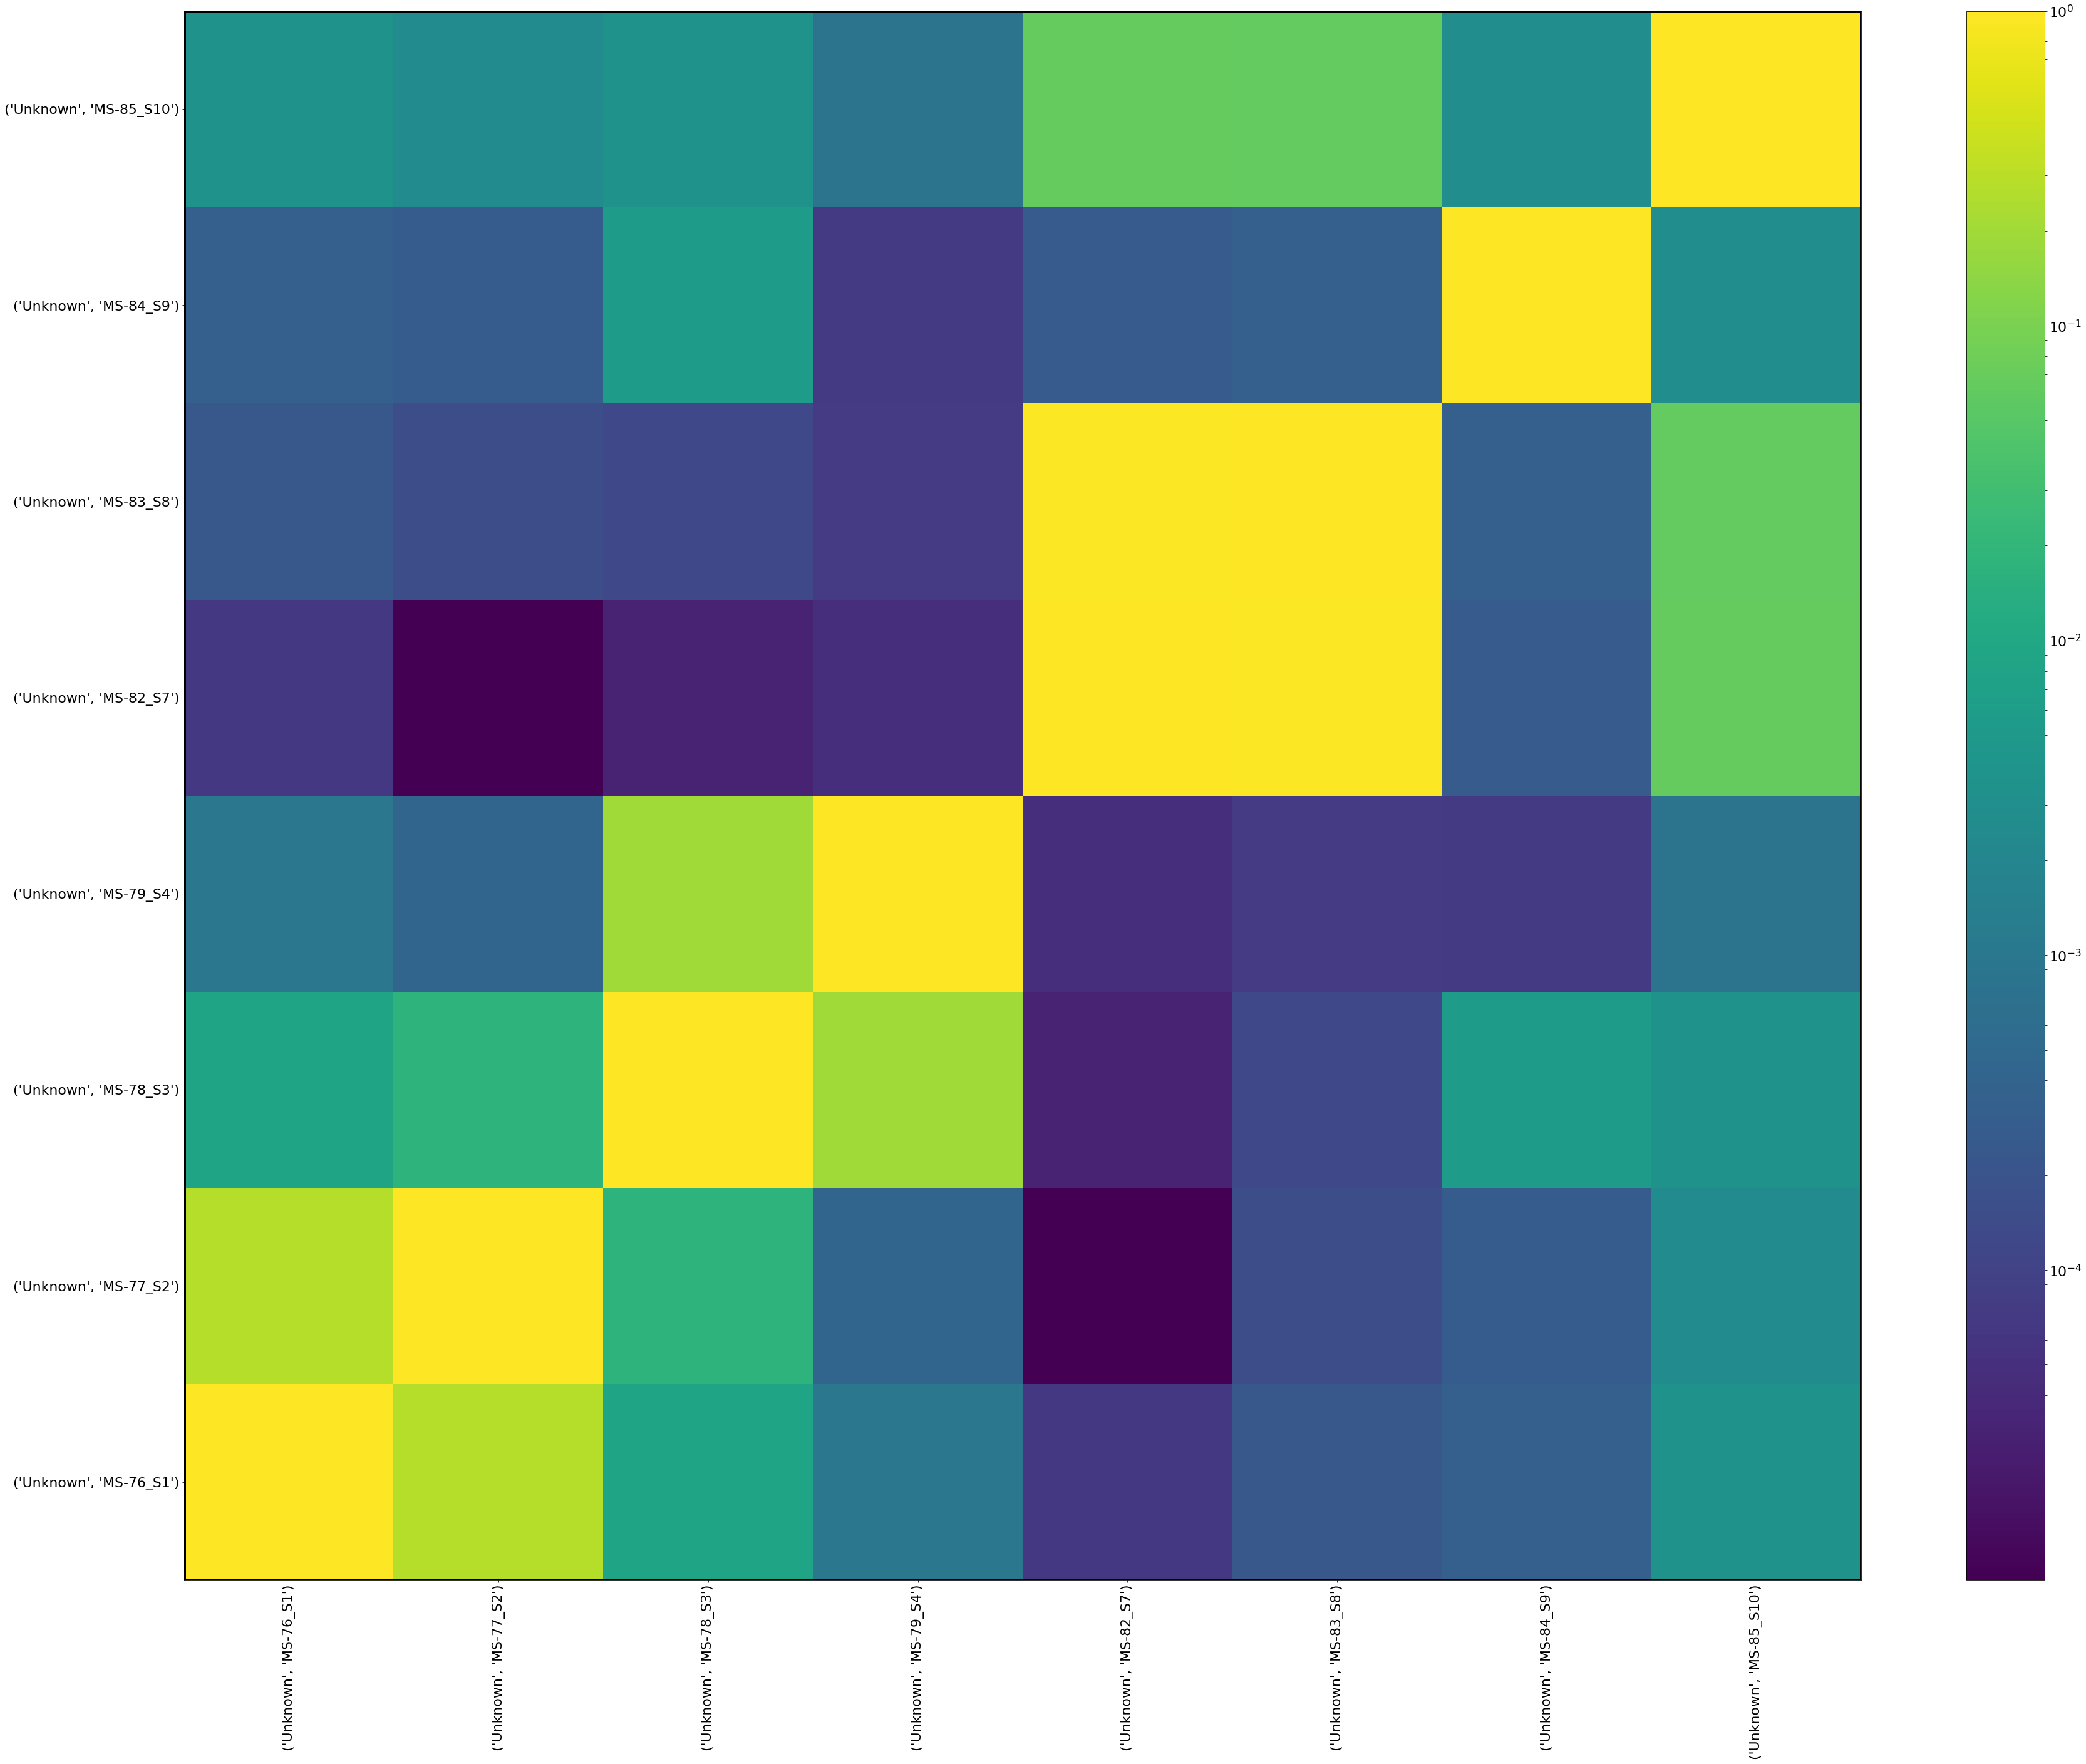

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.057169029924312616 0.18282011291189623
mean diff patient nan nan
threshold nan


/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f43071d96a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f43071d9f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f43071d9550>,
 'medians': [<matplotlib.lines.Line2D at 0x7f43071dd7f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43071ddc18>,
 'means': []}

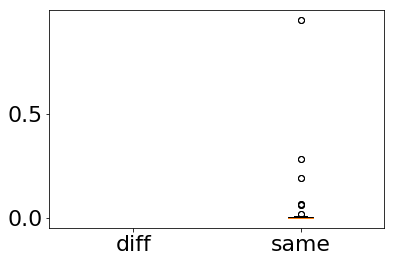

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

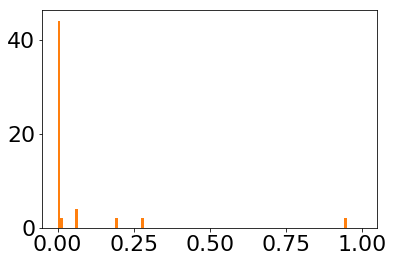

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

Wrote runMaria4-similarity-IGH_HUMAN.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.034736090554933e-05
max value: 1.0
Wrote runMaria4-similarity-IGH_HUMAN-highlighted.pdf to disk


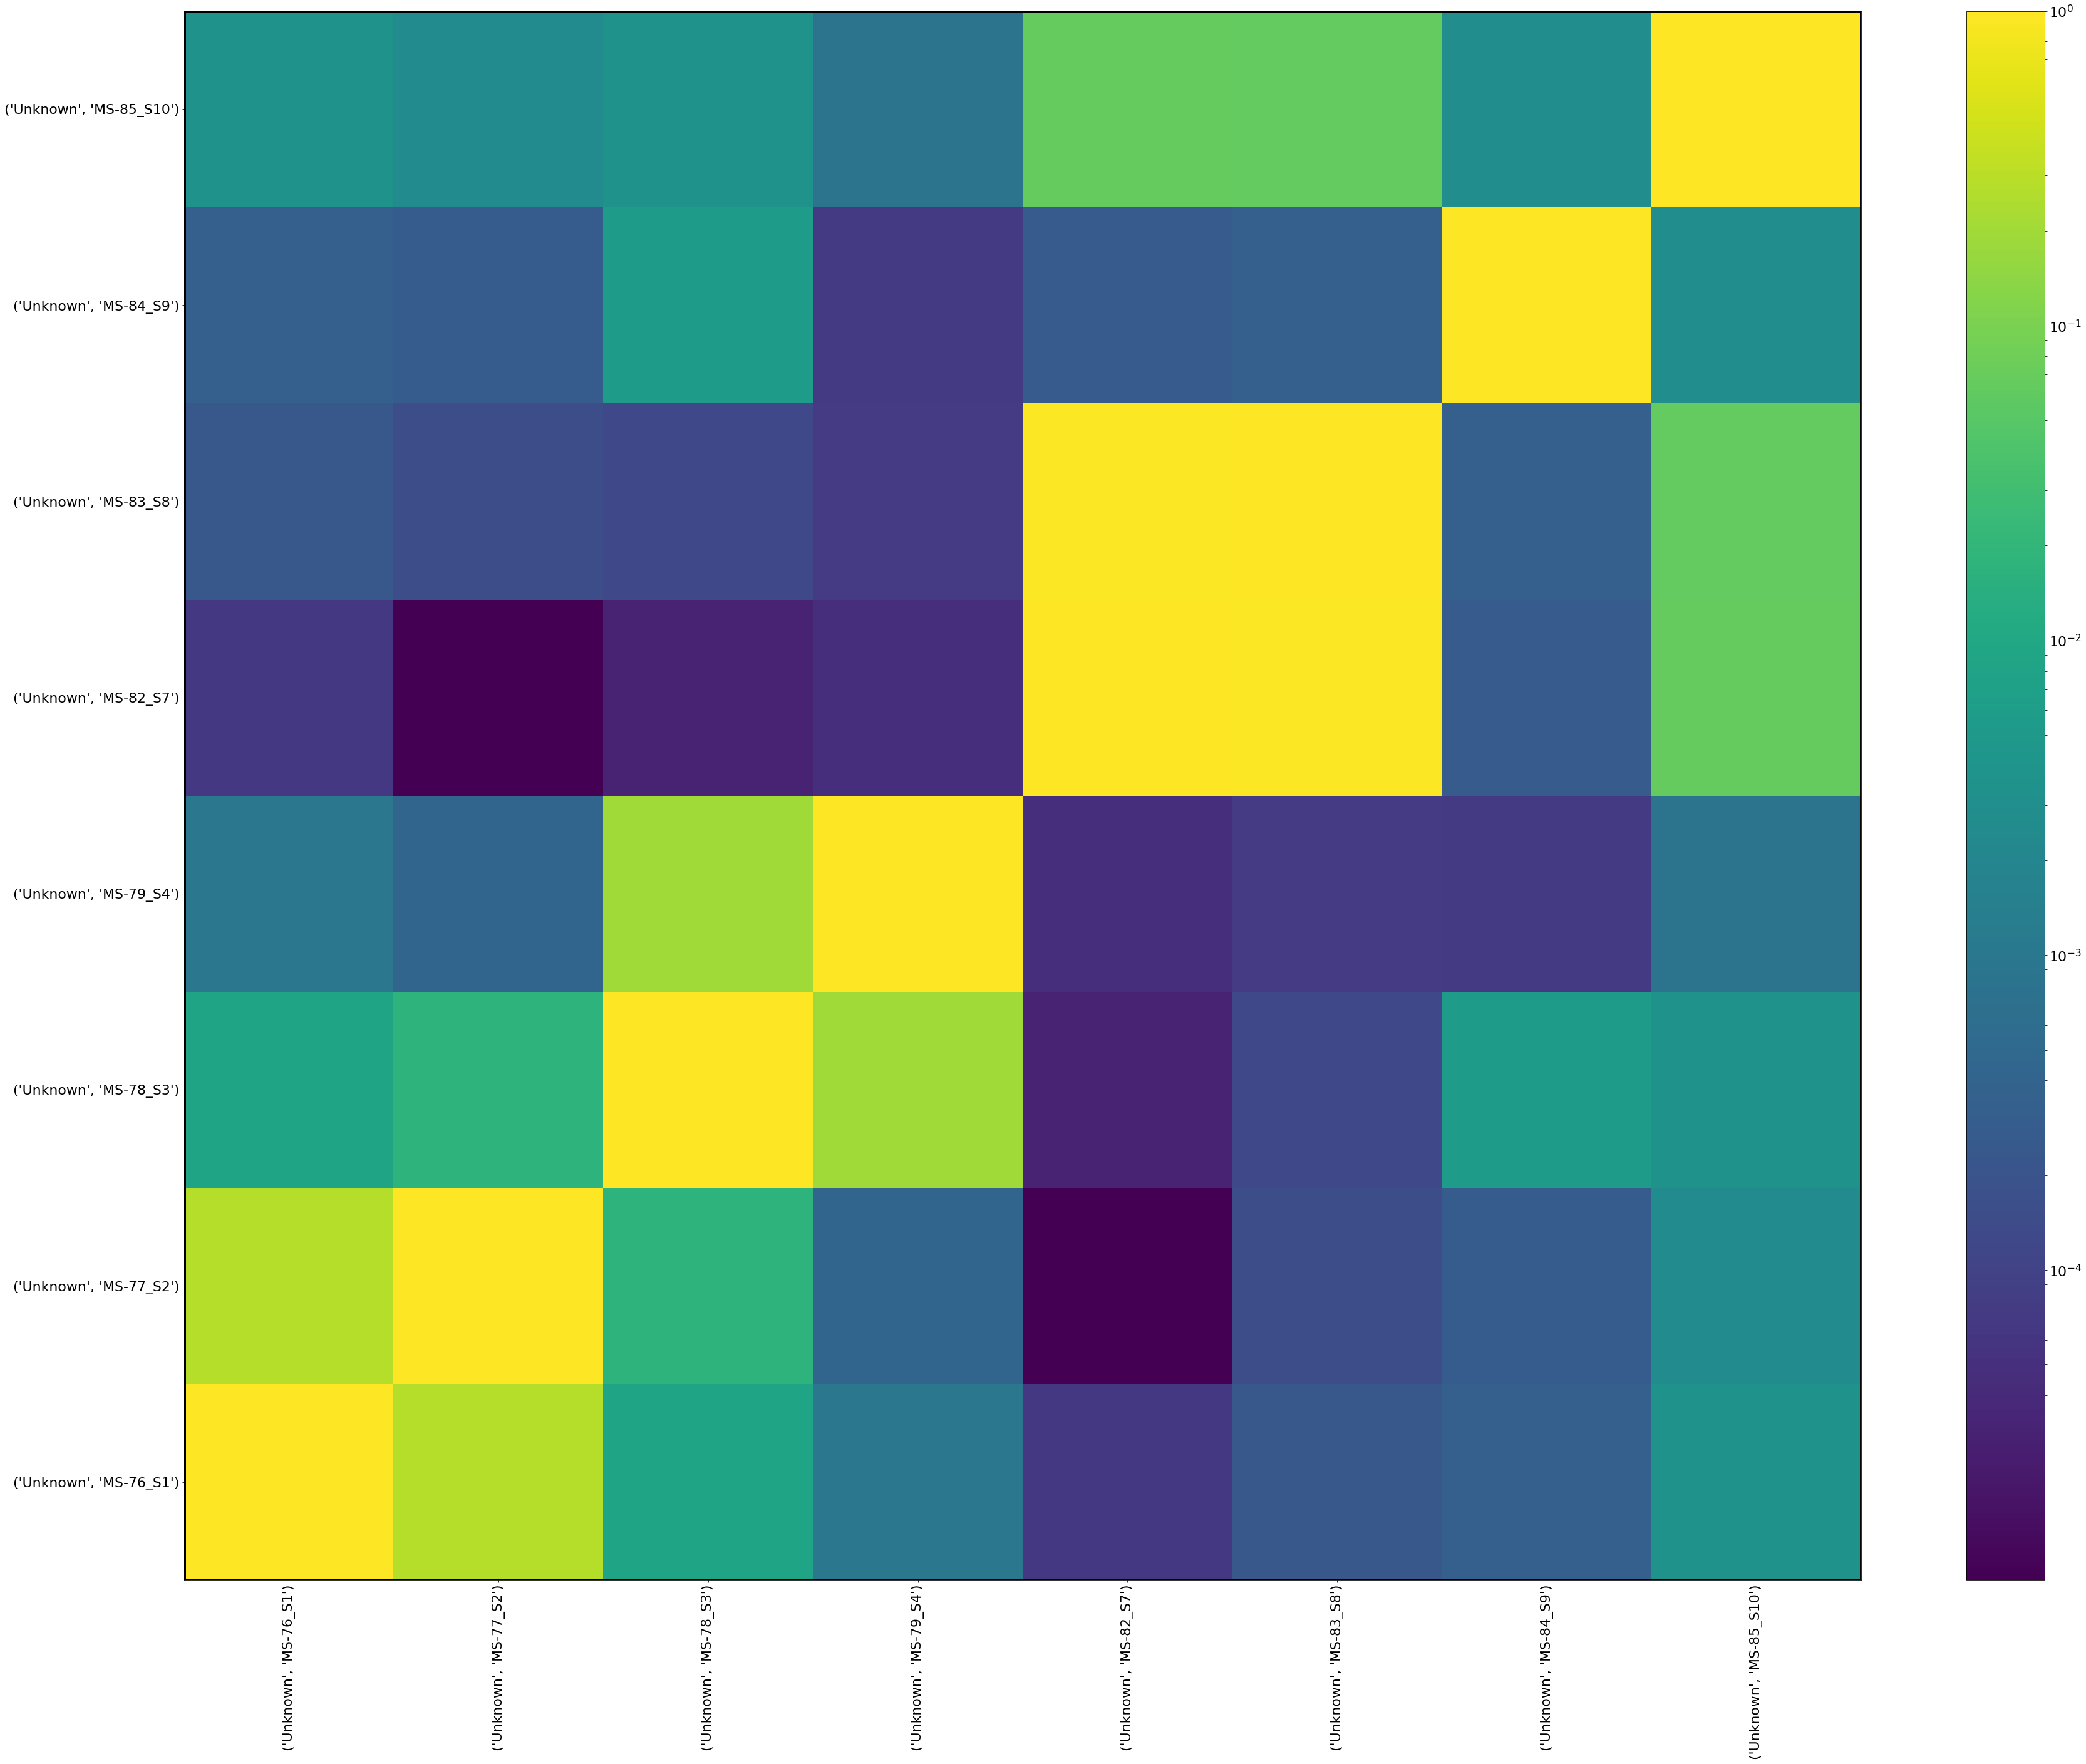

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)